In [102]:
%load_ext autoreload
%autoreload 2

import pathlib

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.1f' % x)
import scipy.stats
import numpy as np

import plotly.express as px
import plotly.graph_objs as go

from data_handlers.network import parse_bwms
from data_handlers.procmem import parse_pidstat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
experiment_path = pathlib.Path(f"/storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/24/")

In [209]:
name_replacement = {
    "epidemic": "Epidemic",
    "cadr_epidemic": "ProgDTN Epidemic",
    "binary_spray": "Binary Spray",
    "cadr_spray": "ProgDTN Binary Spray",
    "prophet": "PRoPHET",
    "dtlsr": "DTLSR",
    "cadr_responders": "ProgDTN Emergency",
    "1000": "1kB",
    "1000000": "1MB",
}

routing_color_map = {
    "Epidemic": "#636EFA",
    "ProgDTN Epidemic": "#EF553B",
    "Binary Spray": "#00CC96",
    "ProgDTN Binary Spray": "#AB63FA",
    "PRoPHET": "#FFA15A",
    "DTLSR": "#FF6692",
    "ProgDTN Emergency": "#19D3F3"
}

In [110]:
def mean_confidence_interval(data, confidence=0.95):
    if isinstance(data.iloc[0], str):
        return data.iloc[0]
    
    a = 1.0 * np.array(data)
    n = len(a)
    h = scipy.stats.sem(a) * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

def error_band_line(error_y_mode=None, **kwargs):
    """Extension of `plotly.express.line` to use error bands."""
    ERROR_MODES = {'bar','band','bars','bands',None}
    if error_y_mode not in ERROR_MODES:
        raise ValueError(f"'error_y_mode' must be one of {ERROR_MODES}, received {repr(error_y_mode)}.")
    if error_y_mode in {'bar','bars',None}:
        fig = px.line(**kwargs)
    elif error_y_mode in {'band','bands'}:
        if 'error_y' not in kwargs:
            raise ValueError(f"If you provide argument 'error_y_mode' you must also provide 'error_y'.")
        figure_with_error_bars = px.line(**kwargs)
        fig = px.line(**{arg: val for arg,val in kwargs.items() if arg != 'error_y'})
        for data in figure_with_error_bars.data:
            x = list(data['x'])
            y_upper = list(data['y'] + data['error_y']['array'])
            y_lower = list(data['y'] - data['error_y']['array'] if data['error_y']['arrayminus'] is None else data['y'] - data['error_y']['arrayminus'])
            color = f"rgba({tuple(int(data['line']['color'].lstrip('#')[i:i+2], 16) for i in (0, 2, 4))},.3)".replace('((','(').replace('),',',').replace(' ','')
            fig.add_trace(
                go.Scatter(
                    x = x+x[::-1],
                    y = y_upper+y_lower[::-1],
                    fill = 'toself',
                    fillcolor = color,
                    line = dict(
                        color = 'rgba(255,255,255,0)'
                    ),
                    hoverinfo = "skip",
                    showlegend = False,
                    legendgroup = data['legendgroup'],
                    xaxis = data['xaxis'],
                    yaxis = data['yaxis'],
                )
            )
        # Reorder data as said here: https://stackoverflow.com/a/66854398/8849755
        reordered_data = []
        for i in range(int(len(fig.data)/2)):
            reordered_data.append(fig.data[i+int(len(fig.data)/2)])
            reordered_data.append(fig.data[i])
        fig.data = tuple(reordered_data)
    return fig

In [190]:
network_df = parse_bwms(experiment_path)

Parsing configuarion 1000, 50, binary_spray in /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/24/ids/1047
Parsing configuarion 1000, 50, cadr_responders in /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/24/ids/983
Parsing configuarion 1000000, 100, prophet in /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/24/ids/1137
Parsing configuarion 1000, 10, cadr_spray in /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/24/ids/910
Parsing configuarion 1000000, 50, cadr_responders in /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/24/ids/967
Parsing configuarion 1000000, 10, binary_spray in /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/24/ids/1075
Parsing configuarion 1000, 50, prophet in /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/24/ids/1196
Parsing configuario

In [191]:
procmem_df = parse_pidstat(experiment_path)

Parsing configuarion 1000, 50, binary_spray in /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/24/ids/1047
Parsing configuarion 1000, 50, cadr_responders in /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/24/ids/983
Parsing configuarion 1000000, 100, prophet in /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/24/ids/1137
Parsing configuarion 1000, 10, cadr_spray in /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/24/ids/910
Parsing configuarion 1000000, 50, cadr_responders in /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/24/ids/967
Parsing configuarion 1000000, 10, binary_spray in /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/24/ids/1075
Parsing configuarion 1000, 50, prophet in /storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/binary_files/24/ids/1196
Parsing configuario

In [202]:
merged = procmem_df.merge(network_df, left_index=True, right_index=True).reset_index()

In [210]:
cleared = merged[merged["routing"].isin(["epidemic", "cadr_epidemic", "cadr_responders"])]
cleared.replace(name_replacement, inplace=True)
cleared['%CPU'] = cleared['%CPU'] / 31

cleared["dt"] = pd.to_timedelta(cleared["dt"], unit="S")
cleared.set_index("dt", inplace=True)
cleared_mean = cleared.groupby(["routing"]).resample("1T").mean()
cleared_std = cleared.groupby(["routing"]).resample("1T").agg(mean_confidence_interval)

#cleared.sort_values("dt", inplace=True)
cleared_mean = cleared_mean.reset_index()
#cleared_std = cleared_std.reset_index()

<ipython-input-210-aaebf3ea4aa5>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-210-aaebf3ea4aa5>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



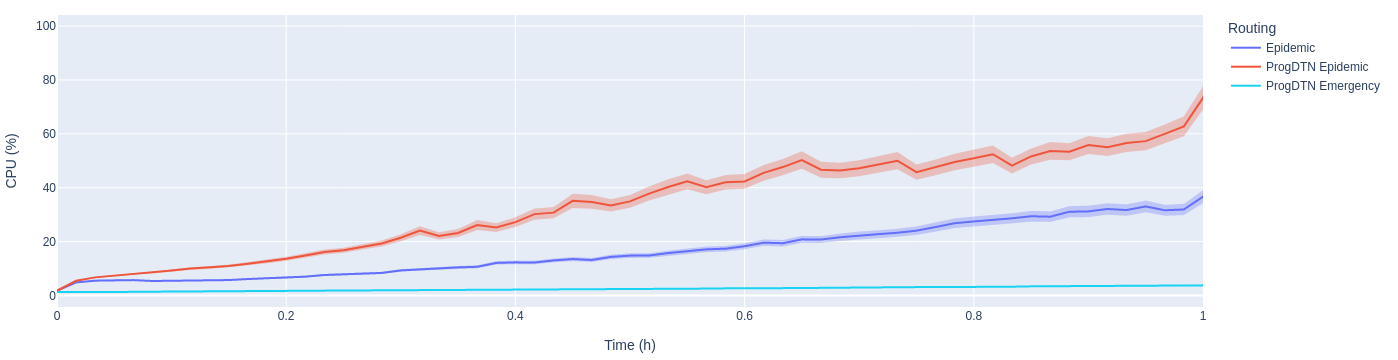

In [215]:
fig = error_band_line(
    data_frame=cleared_mean,
    x=cleared_mean["dt"].dt.total_seconds() / 3600, 
    y="%CPU",
    error_y=cleared_std["%CPU"],
    error_y_mode="band",
    color="routing",
    color_discrete_map=routing_color_map,
    category_orders={
        "routing": ["Epidemic", "ProgDTN Epidemic", "ProgDTN Emergency"],
    },
    labels={
        "x": "Time (h)",
        "routing": "Routing",
        "%CPU": "CPU (%)"
    },
)

fig.layout.margin = go.layout.Margin(l=10, r=10, b=10, t=15)
fig.update_layout(width=800, height=200, xaxis_range=[0,1])

fig.write_image("/storage/research_data/sommer2020cadr/maci-docker-compose/maci_data/evaluation/paper/figures/cpu.pdf")
fig.show()